In [24]:
import torch
import torch.nn as nn
import accelerate
from torch.utils.data import DataLoader
from torchvision.transforms import (
    Compose, Resize, ToTensor, Normalize
)
from transformers import ViTModel,ViTConfig, ViTForImageClassification, Trainer, TrainingArguments
from datasets import DatasetDict
dataset = DatasetDict.load_from_disk("./chest_xray_clasnsificatio")

image_size = 224
transforms = Compose([
    Resize((image_size, image_size)),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

def preprocess_data(example):
    example['pixel_values'] = transforms(example['image'])
    return example

dataset = dataset.map(preprocess_data, batched=False)

dataset = dataset.remove_columns(["image_file_path", "image"])

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 4077
    })
    validation: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 1165
    })
    test: Dataset({
        features: ['labels', 'pixel_values'],
        num_rows: 582
    })
})


In [ ]:
class ConvStem(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=2, padding=3, output_size=None):
        super(ConvStem, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.output_size = output_size  

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.pool(x)

        if self.output_size:
            x = nn.functional.interpolate(x, size=self.output_size, mode='bilinear', align_corners=False)
        return x


class ViTWithConvStem(nn.Module):
    def __init__(self, config, conv_out_channels=64):
        super().__init__()
        patch_size = config.patch_size
        image_size = config.image_size

        aligned_size = (image_size // patch_size) * patch_size

        self.conv_stem = ConvStem(
            in_channels=config.num_channels,
            out_channels=conv_out_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            output_size=(aligned_size, aligned_size), 
        )
        self.vit = ViTForImageClassification(config)

    def forward(self, pixel_values, labels=None):
        # Pass through ConvStem
        x = self.conv_stem(pixel_values)

        batch_size, channels, height, width = x.shape
        patch_size = self.vit.config.patch_size

        x = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()
        x = x.view(batch_size, -1, patch_size * patch_size * channels)

        outputs = self.vit(pixel_values=pixel_values, labels=labels)
        return outputs


config = ViTConfig(
    image_size=224,
    num_channels=3,
    patch_size=16,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    num_labels=2
)


model = ViTWithConvStem(config)

In [26]:
model.load_state_dict(torch.load('model_parameters_1202.pth'))

C:\Users\19811\AppData\Local\Temp\ipykernel_33104\1299705689.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_parameters_1202.pth'

<All keys matched successfully>

In [27]:
model.eval

<bound method Module.eval of ViTWithConvStem(
  (conv_stem): ConvStem(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
            

In [17]:
training_args = TrainingArguments(
    output_dir="./vit_model_1203_1",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_total_limit=2,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False
)

from evaluate import load

metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return metric.compute(predictions=predictions.numpy(), references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=None,
    compute_metrics=compute_metrics
)

C:\Users\19811\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\19811\AppData\Local\Temp\ipykernel_33104\2483562209.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
results = trainer.evaluate(dataset["test"])
print("Test Results:", results)

  0%|          | 0/37 [00:00<?, ?it/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tzeng5 (tzeng5-nc-state-university). Use `wandb login --relogin` to force relogin


Test Results: {'eval_loss': 0.19924920797348022, 'eval_model_preparation_time': 0.0022, 'eval_accuracy': 0.9415807560137457, 'eval_runtime': 92.6813, 'eval_samples_per_second': 6.28, 'eval_steps_per_second': 0.399}


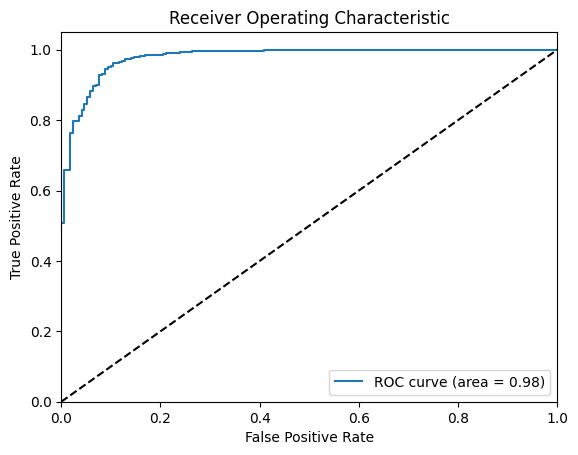

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt



test_dataset = dataset["test"]
logits, labels = [], []

for i in range(len(test_dataset)):
    inputs = torch.tensor(test_dataset[i]["pixel_values"]).unsqueeze(0)
    with torch.no_grad():
        output = model(inputs)
    logits.append(output.logits.squeeze(0).numpy())
    labels.append(test_dataset[i]["labels"])

logits = np.array(logits)
labels = np.array(labels)



probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()

fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = roc_auc_score(labels, probs)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
logits, labels = [], []

for i in range(len(test_dataset)):
    inputs = torch.tensor(test_dataset[i]["pixel_values"]).unsqueeze(0)
    with torch.no_grad():
        output = model(inputs)
    logits.append(output.logits.squeeze(0).numpy())  
    labels.append(test_dataset[i]["labels"])    

logits = np.array(logits)
labels = np.array(labels)

if logits.shape[0] != labels.shape[0]:
    print(f"Error: logits samples ({logits.shape[0]}) and labels samples ({labels.shape[0]}) do not match.")
    exit()


predicted_probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
predicted_labels = (predicted_probs >= 0.5).astype(int)


assert len(predicted_labels) == len(labels), "Predicted labels and true labels lengths do not match."


from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

f1 = f1_score(labels, predicted_labels, average='binary')
accuracy = accuracy_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels, average='binary')
recall = recall_score(labels, predicted_labels, average='binary')
conf_matrix = confusion_matrix(labels, predicted_labels)

print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(labels, predicted_labels))


F1 Score: 0.96
Accuracy: 0.94
Precision: 0.94
Recall: 0.98

Confusion Matrix:
[[145  26]
 [  8 403]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       171
           1       0.94      0.98      0.96       411

    accuracy                           0.94       582
   macro avg       0.94      0.91      0.93       582
weighted avg       0.94      0.94      0.94       582



In [9]:
from transformers import ViTForImageClassification

model0 = ViTForImageClassification.from_pretrained("./vit_model")

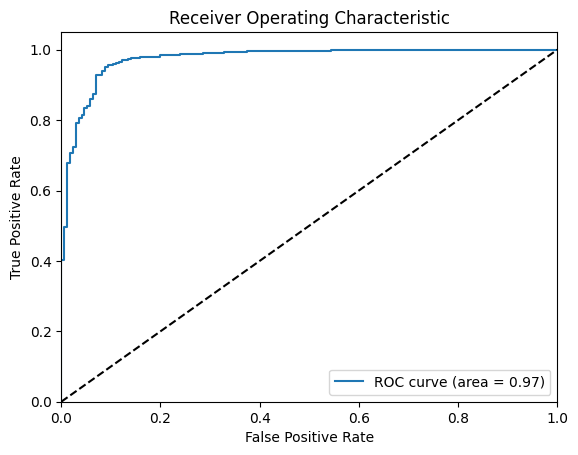

In [ ]:
test_dataset = dataset["test"]
logits, labels = [], []

for i in range(len(test_dataset)):
    inputs = torch.tensor(test_dataset[i]["pixel_values"]).unsqueeze(0)
    with torch.no_grad():
        output = model0(inputs)
    logits.append(output.logits.squeeze(0).numpy())
    labels.append(test_dataset[i]["labels"])

logits = np.array(logits)
labels = np.array(labels)

probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()

fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = roc_auc_score(labels, probs)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [11]:

f1 = f1_score(labels, predicted_labels, average='binary')
accuracy = accuracy_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels, average='binary')
recall = recall_score(labels, predicted_labels, average='binary')
conf_matrix = confusion_matrix(labels, predicted_labels)

print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(labels, predicted_labels))


F1 Score: 0.96
Accuracy: 0.94
Precision: 0.94
Recall: 0.98

Confusion Matrix:
[[145  26]
 [  8 403]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       171
           1       0.94      0.98      0.96       411

    accuracy                           0.94       582
   macro avg       0.94      0.91      0.93       582
weighted avg       0.94      0.94      0.94       582

